In [2]:
import sys
import os
!{sys.executable} -m pip install -r requirements.txt

DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621


In [3]:
import kagglehub
import cv2
import matplotlib.pyplot as plt

/opt/homebrew/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
path = kagglehub.dataset_download("joosthazelzet/lego-brick-images")
IMG_DIR = path + "/LEGO brick images v1/2357 Brick corner 1x2x2/"

In [5]:
files = os.listdir(IMG_DIR)
# list all files within IMG_DIR
files

['201706171206-0258.png',
 '201706171206-0264.png',
 '201706171206-0270.png',
 '201706171206-0099.png',
 '201706171206-0066.png',
 '201706171206-0072.png',
 '201706171206-0112.png',
 '201706171206-0106.png',
 '201706171206-0338.png',
 '201706171206-0310.png',
 '201706171206-0304.png',
 '201706171206-0305.png',
 '201706171206-0311.png',
 '201706171206-0339.png',
 '201706171206-0107.png',
 '201706171206-0113.png',
 '201706171206-0073.png',
 '201706171206-0067.png',
 '201706171206-0098.png',
 '201706171206-0271.png',
 '201706171206-0265.png',
 '201706171206-0259.png',
 '201706171206-0298.png',
 '201706171206-0273.png',
 '201706171206-0267.png',
 '201706171206-0059.png',
 '201706171206-0071.png',
 '201706171206-0065.png',
 '201706171206-0139.png',
 '201706171206-0105.png',
 '201706171206-0111.png',
 '201706171206-0307.png',
 '201706171206-0313.png',
 '201706171206-0312.png',
 '201706171206-0306.png',
 '201706171206-0110.png',
 '201706171206-0104.png',
 '201706171206-0138.png',
 '2017061712

In [6]:
def find_edges(img):
    gray_img = img
    img_blur = img
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img_blur = cv2.GaussianBlur(gray_img, (3,3), 0)
    edge_img = cv2.Canny(img,100,200)
    edge_img = cv2.cvtColor(edge_img, cv2.COLOR_GRAY2BGR)
    return gray_img, img_blur, edge_img

In [9]:
img = cv2.imread("/Users/anvay-coder/document-scanner/document_2_1752701338803.jpg")
gray_img, img_blur, edge_img = find_edges(img)

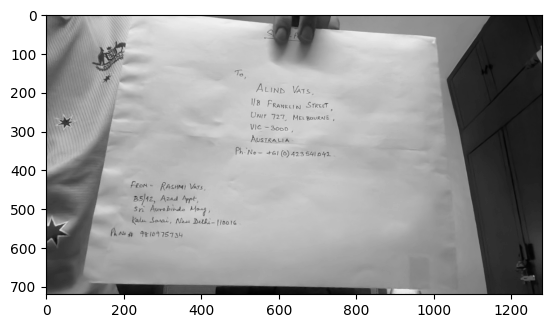

In [10]:
plt.imsave("img_gray.png", gray_img)
plt.imshow(gray_img, cmap='gray')

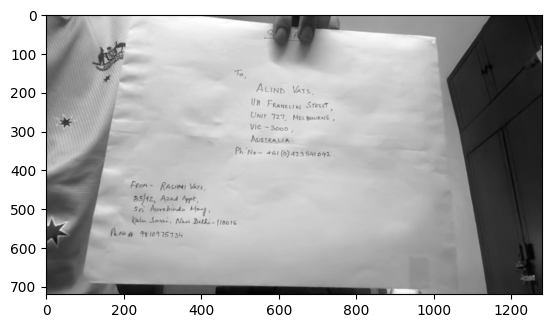

In [11]:
plt.imsave("img_blur.png", img_blur)
plt.imshow(img_blur, cmap='gray')

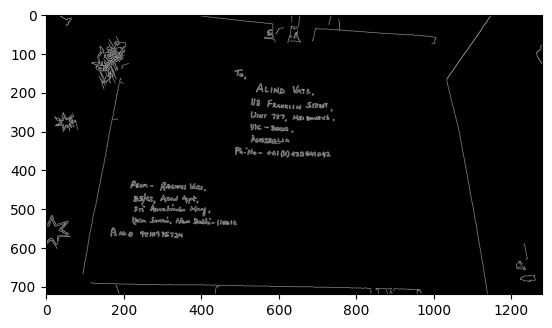

In [12]:
plt.imsave("img_edge.png", edge_img)
plt.imshow(edge_img, cmap='gray')

In [19]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def document_scanner(image, debug=False):
    """
    Document scanner that detects paper corners within the image.
    
    Args:
        image: Input color image containing a document
        debug: If True, shows intermediate processing steps
        
    Returns:
        Tuple of (original, corners_visualization, scanned_document)
    """
    original = image.copy()
    h, w = image.shape[:2]
    
    # Resize for processing if too large
    if h > 1000:
        scale = 1000 / h
        image = cv2.resize(image, None, fx=scale, fy=scale)
        h, w = image.shape[:2]
    
    # STEP 1: Preprocessing to enhance document edges
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Apply bilateral filter to reduce noise while preserving edges
    filtered = cv2.bilateralFilter(gray, 9, 75, 75)
    
    # STEP 2: Enhanced edge detection for document boundaries
    # Use adaptive threshold to handle varying lighting
    adaptive_thresh = cv2.adaptiveThreshold(
        filtered, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
        cv2.THRESH_BINARY, 11, 10
    )
    
    # Canny edge detection with optimized parameters
    edges = cv2.Canny(filtered, 30, 80, apertureSize=3)
    
    # Combine both edge detection methods
    combined_edges = cv2.bitwise_or(edges, adaptive_thresh)
    
    # Morphological operations to connect nearby edges
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
    combined_edges = cv2.morphologyEx(combined_edges, cv2.MORPH_CLOSE, kernel)
    combined_edges = cv2.dilate(combined_edges, kernel, iterations=1)
    
    # STEP 3: Find document contour
    contours, _ = cv2.findContours(combined_edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = sorted(contours, key=cv2.contourArea, reverse=True)
    
    document_contour = None
    
    # Look for the largest rectangular contour (the document)
    for contour in contours:
        # Calculate contour area
        area = cv2.contourArea(contour)
        
        # Skip very small contours (noise)
        if area < w * h * 0.01:
            continue
            
        # Approximate contour to polygon
        perimeter = cv2.arcLength(contour, True)
        epsilon = 0.02 * perimeter
        approx = cv2.approxPolyDP(contour, epsilon, True)
        
        # Look for quadrilateral (4 corners)
        if len(approx) == 4:
            # Check if it's a reasonable size (not too small, not the entire image)
            if w * h * 0.05 < area < w * h * 0.95:
                document_contour = approx
                break
    
    # If no good 4-corner contour found, try with more relaxed parameters
    if document_contour is None:
        for contour in contours:
            area = cv2.contourArea(contour)
            if area < w * h * 0.01:
                continue
                
            perimeter = cv2.arcLength(contour, True)
            epsilon = 0.05 * perimeter  # More relaxed approximation
            approx = cv2.approxPolyDP(contour, epsilon, True)
            
            if len(approx) == 4 and w * h * 0.02 < area < w * h * 0.98:
                document_contour = approx
                break
    
    # Last fallback: use the largest contour and get its bounding rectangle
    if document_contour is None and len(contours) > 0:
        largest_contour = contours[0]
        rect = cv2.minAreaRect(largest_contour)
        document_contour = np.int32(cv2.boxPoints(rect))
    
    # Ultimate fallback: use entire image (but this shouldn't happen with real documents)
    if document_contour is None:
        document_contour = np.array([[50, 50], [w-50, 50], [w-50, h-50], [50, h-50]], dtype=np.float32)
    
    # STEP 4: Extract and order corners
    corners = document_contour.reshape(4, 2).astype(np.float32)
    
    def order_corners(pts):
        """Order points: top-left, top-right, bottom-right, bottom-left"""
        rect = np.zeros((4, 2), dtype=np.float32)
        
        # Sum and difference of coordinates
        s = pts.sum(axis=1)
        diff = np.diff(pts, axis=1)
        
        rect[0] = pts[np.argmin(s)]      # Top-left (smallest sum)
        rect[2] = pts[np.argmax(s)]      # Bottom-right (largest sum)
        rect[1] = pts[np.argmin(diff)]   # Top-right (smallest diff)
        rect[3] = pts[np.argmax(diff)]   # Bottom-left (largest diff)
        
        return rect
    
    corners = order_corners(corners)
    
    # STEP 5: Calculate output dimensions
    def distance(p1, p2):
        return np.sqrt((p1[0] - p2[0])**2 + (p1[1] - p2[1])**2)
    
    # Calculate width and height of output rectangle
    width_top = distance(corners[0], corners[1])
    width_bottom = distance(corners[3], corners[2])
    height_left = distance(corners[0], corners[3])
    height_right = distance(corners[1], corners[2])
    
    max_width = int(max(width_top, width_bottom))
    max_height = int(max(height_left, height_right))
    
    # STEP 6: Perspective transformation
    dst_corners = np.array([
        [0, 0],
        [max_width - 1, 0],
        [max_width - 1, max_height - 1],
        [0, max_height - 1]
    ], dtype=np.float32)
    
    # Get perspective transform matrix
    M = cv2.getPerspectiveTransform(corners, dst_corners)
    
    # Apply transformation to original image
    warped = cv2.warpPerspective(image, M, (max_width, max_height))
    
    # STEP 7: Enhance scanned document
    warped_gray = cv2.cvtColor(warped, cv2.COLOR_BGR2GRAY)
    
    # Apply adaptive thresholding for clean text
    scanned = cv2.adaptiveThreshold(
        warped_gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
        cv2.THRESH_BINARY, 11, 10
    )
    
    # STEP 8: Visualize corners and edges
    corners_viz = image.copy()
    
    # Draw detected corners with labels
    corner_labels = ['TL', 'TR', 'BR', 'BL']
    colors = [(0, 255, 0), (255, 0, 0), (0, 0, 255), (255, 255, 0)]
    
    for i, (corner, label, color) in enumerate(zip(corners, corner_labels, colors)):
        cv2.circle(corners_viz, tuple(corner.astype(int)), 10, color, -1)
        cv2.putText(corners_viz, label, (int(corner[0])+15, int(corner[1])-10), 
                   cv2.FONT_HERSHEY_SIMPLEX, 0.8, color, 2)
    
    # Draw edges between corners
    for i in range(4):
        pt1 = tuple(corners[i].astype(int))
        pt2 = tuple(corners[(i + 1) % 4].astype(int))
        cv2.line(corners_viz, pt1, pt2, (0, 255, 255), 3)
    
    # Debug visualization
    if debug:
        plt.figure(figsize=(20, 5))
        plt.subplot(1, 5, 1), plt.imshow(cv2.cvtColor(original, cv2.COLOR_BGR2RGB)), plt.title('Original')
        plt.subplot(1, 5, 2), plt.imshow(filtered, cmap='gray'), plt.title('Filtered')
        plt.subplot(1, 5, 3), plt.imshow(combined_edges, cmap='gray'), plt.title('Combined Edges')
        plt.subplot(1, 5, 4), plt.imshow(cv2.cvtColor(corners_viz, cv2.COLOR_BGR2RGB)), plt.title('Document Corners')
        plt.subplot(1, 5, 5), plt.imshow(scanned, cmap='gray'), plt.title('Scanned Document')
        plt.tight_layout()
        plt.show()
    
    return original, corners_viz, scanned

# Test function
def test_scanner(image_path):
    """Test the document scanner"""
    image = cv2.imread(image_path)
    if image is None:
        print(f"Error: Could not load image from {image_path}")
        return
    
    original, corners_viz, scanned = document_scanner(image, debug=True)
    
    # Display final results
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1), plt.imshow(cv2.cvtColor(original, cv2.COLOR_BGR2RGB)), plt.title('Original Image')
    plt.subplot(1, 3, 2), plt.imshow(cv2.cvtColor(corners_viz, cv2.COLOR_BGR2RGB)), plt.title('Paper Corner Detection')
    plt.subplot(1, 3, 3), plt.imshow(scanned, cmap='gray'), plt.title('Scanned Paper')
    plt.tight_layout()
    plt.show()
    
    return original, corners_viz, scanned

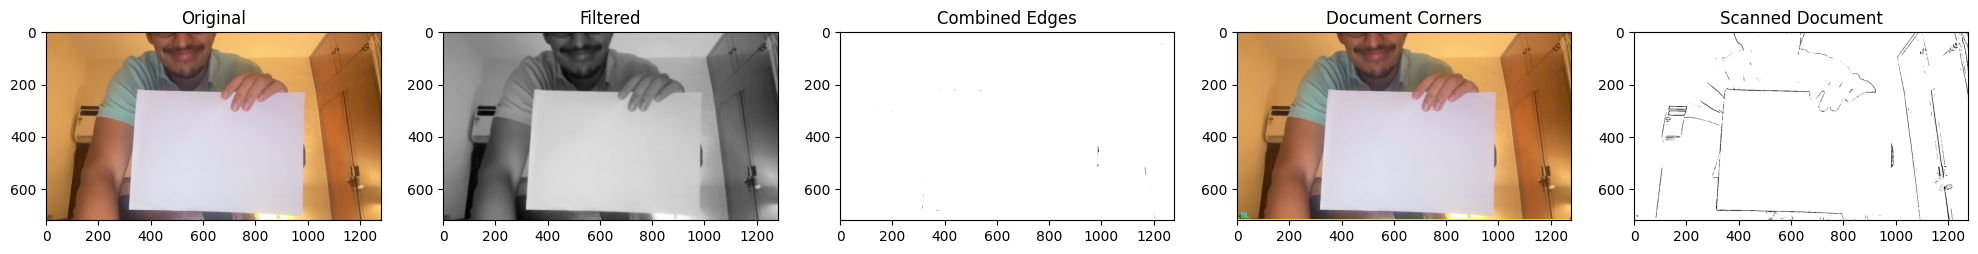

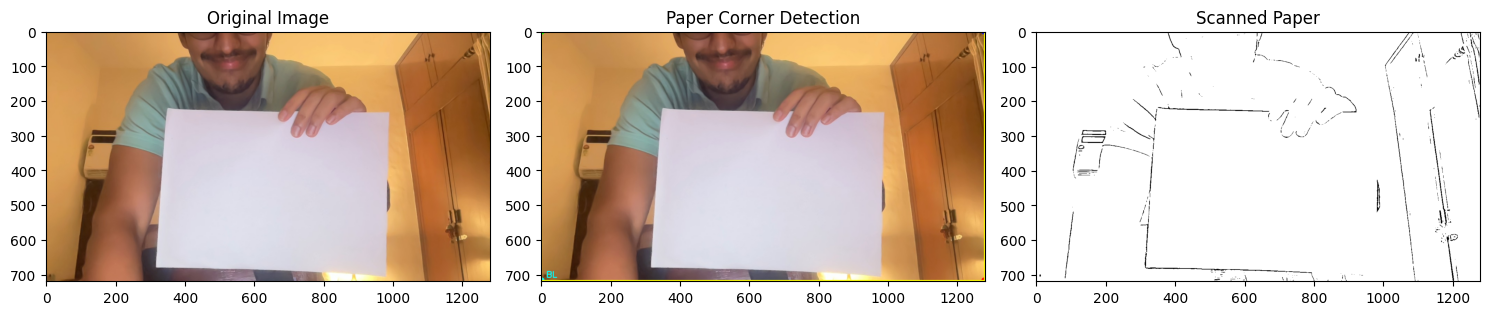

In [35]:
# Test different document images
# /Users/anvay-coder/document-scanner/document_1_1752773781461.jpg
# /Users/anvay-coder/document-scanner/document_2_1752773778776.jpg
img_path = "/Users/anvay-coder/document-scanner/document_2_1752773778776.jpg"
corner_groups, viz_image, scanned = test_scanner(img_path)

In [36]:
cv2.imwrite("scanned_document.png", scanned)
cv2.imwrite("corners_visualization.png", corner_groups)

True

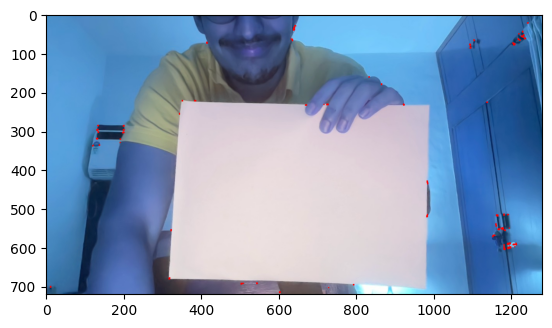

In [73]:
img = cv2.imread(img_path)
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
gray = np.float32(gray)

gray = cv2.GaussianBlur(gray, (3,3), 0)

dst = cv2.cornerHarris(gray,3,3,0.04)
#result is dilated for marking the corners, not important
dst = cv2.dilate(dst,None)
 
# Threshold for an optimal value, it may vary depending on the image.
img[dst>0.01*dst.max()]=[255,0,0]

plt.imshow(img, cmap='gray')

In [101]:
import cv2
import numpy as np

# Load image
# /Users/anvay-coder/document-scanner/document_1_1752773781461.jpg
# /Users/anvay-coder/document-scanner/document_2_1752773778776.jpg
img = cv2.imread("/Users/anvay-coder/document-scanner/document_1_1752773781461.jpg")
original = img.copy()
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Preprocess
blurred = cv2.GaussianBlur(gray, (5, 5), 0)
edges = cv2.Canny(blurred, 50, 150)

# Find contours
contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

# Filter quadrilaterals
quads = []

for cnt in contours:
    # Approximate contour
    epsilon = 0.02 * cv2.arcLength(cnt, True)
    approx = cv2.approxPolyDP(cnt, epsilon, True)

    # Check if it's a quadrilateral
    if len(approx) == 4 and cv2.isContourConvex(approx):
        area = cv2.contourArea(approx)
        if area > 1000:  # discard very small areas
            quads.append((area, approx))

# Sort by area, largest first
quads = sorted(quads, key=lambda x: x[0], reverse=True)

# Draw all plausible quadrilaterals
for area, quad in quads:
    cv2.drawContours(original, [quad], -1, (0, 255, 0), 2)

In [102]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
from itertools import product
import json

def document_scanner_with_hyperparams(image_path, blur_kernel, canny_low, canny_high, 
                                     epsilon_factor, min_area, save_dir):
    """
    Document scanner with configurable hyperparameters
    
    Args:
        image_path: Path to input image
        blur_kernel: Gaussian blur kernel size (odd number)
        canny_low: Lower threshold for Canny edge detection
        canny_high: Upper threshold for Canny edge detection
        epsilon_factor: Factor for contour approximation (0.01-0.1)
        min_area: Minimum area threshold for quadrilaterals
        save_dir: Directory to save results
    
    Returns:
        Number of quadrilaterals found, result images
    """
    # Load image
    img = cv2.imread(image_path)
    if img is None:
        print(f"Error: Could not load image from {image_path}")
        return 0, None, None, None
    
    original = img.copy()
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Preprocess with hyperparameters
    blurred = cv2.GaussianBlur(gray, (blur_kernel, blur_kernel), 0)
    edges = cv2.Canny(blurred, canny_low, canny_high)
    
    # Find contours
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    
    # Filter quadrilaterals with hyperparameters
    quads = []
    
    for cnt in contours:
        # Approximate contour
        epsilon = epsilon_factor * cv2.arcLength(cnt, True)
        approx = cv2.approxPolyDP(cnt, epsilon, True)
        
        # Check if it's a quadrilateral
        if len(approx) == 4 and cv2.isContourConvex(approx):
            area = cv2.contourArea(approx)
            if area > min_area:
                quads.append((area, approx))
    
    # Sort by area, largest first
    quads = sorted(quads, key=lambda x: x[0], reverse=True)
    
    # Create visualizations
    result_original = original.copy()
    result_edges = cv2.cvtColor(edges, cv2.COLOR_GRAY2BGR)
    result_contours = original.copy()
    
    # Draw all plausible quadrilaterals
    colors = [(0, 255, 0), (255, 0, 0), (0, 0, 255), (255, 255, 0), (255, 0, 255)]
    for i, (area, quad) in enumerate(quads[:5]):  # Show top 5 quads
        color = colors[i % len(colors)]
        cv2.drawContours(result_contours, [quad], -1, color, 3)
        
        # Label corners
        for j, corner in enumerate(quad):
            pt = tuple(corner[0])
            cv2.circle(result_contours, pt, 8, color, -1)
            cv2.putText(result_contours, f"{i+1}-{j+1}", (pt[0]+10, pt[1]-10), 
                       cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)
    
    # Save results
    os.makedirs(save_dir, exist_ok=True)
    
    # Save images
    cv2.imwrite(os.path.join(save_dir, "original.jpg"), result_original)
    cv2.imwrite(os.path.join(save_dir, "edges.jpg"), result_edges)
    cv2.imwrite(os.path.join(save_dir, "contours.jpg"), result_contours)
    cv2.imwrite(os.path.join(save_dir, "blurred.jpg"), blurred)
    
    # Save hyperparameters and results
    results = {
        "hyperparameters": {
            "blur_kernel": blur_kernel,
            "canny_low": canny_low,
            "canny_high": canny_high,
            "epsilon_factor": epsilon_factor,
            "min_area": min_area
        },
        "results": {
            "num_quadrilaterals": len(quads),
            "quad_areas": [float(area) for area, _ in quads],
            "image_size": img.shape[:2]
        }
    }
    
    with open(os.path.join(save_dir, "results.json"), "w") as f:
        json.dump(results, f, indent=2)
    
    return len(quads), result_original, result_edges, result_contours

def hyperparameter_tuning(image_path, base_output_dir="hyperparameter_results"):
    """
    Perform hyperparameter tuning for document scanner
    
    Args:
        image_path: Path to input image
        base_output_dir: Base directory for saving results
    """
    # Define hyperparameter ranges
    hyperparams = {
        'blur_kernel': [3, 5, 7, 9],  # Gaussian blur kernel sizes
        'canny_low': [30, 50, 70, 100],  # Lower Canny threshold
        'canny_high': [100, 150, 200, 250],  # Upper Canny threshold
        'epsilon_factor': [0.01, 0.02, 0.03, 0.05],  # Contour approximation factor
        'min_area': [500, 1000, 2000, 5000]  # Minimum area threshold
    }
    
    # Create base output directory
    os.makedirs(base_output_dir, exist_ok=True)
    
    # Generate all combinations
    param_combinations = list(product(*hyperparams.values()))
    param_names = list(hyperparams.keys())
    
    print(f"Testing {len(param_combinations)} hyperparameter combinations...")
    
    results_summary = []
    
    for i, params in enumerate(param_combinations):
        # Create parameter dictionary
        param_dict = dict(zip(param_names, params))
        
        # Create directory name from parameters
        dir_name = f"blur{param_dict['blur_kernel']}_canny{param_dict['canny_low']}-{param_dict['canny_high']}_eps{param_dict['epsilon_factor']}_area{param_dict['min_area']}"
        save_dir = os.path.join(base_output_dir, dir_name)
        
        # Run scanner with these parameters
        num_quads, original, edges, contours = document_scanner_with_hyperparams(
            image_path, 
            param_dict['blur_kernel'],
            param_dict['canny_low'],
            param_dict['canny_high'],
            param_dict['epsilon_factor'],
            param_dict['min_area'],
            save_dir
        )
        
        # Store results
        results_summary.append({
            'combination': i + 1,
            'parameters': param_dict,
            'num_quadrilaterals': num_quads,
            'directory': dir_name
        })
        
        # Print progress
        if (i + 1) % 50 == 0:
            print(f"Completed {i + 1}/{len(param_combinations)} combinations")
    
    # Save summary results
    with open(os.path.join(base_output_dir, "hyperparameter_summary.json"), "w") as f:
        json.dump(results_summary, f, indent=2)
    
    # Find best parameters (most quadrilaterals found)
    best_result = max(results_summary, key=lambda x: x['num_quadrilaterals'])
    
    print(f"\nHyperparameter tuning completed!")
    print(f"Total combinations tested: {len(param_combinations)}")
    print(f"Best result: {best_result['num_quadrilaterals']} quadrilaterals found")
    print(f"Best parameters: {best_result['parameters']}")
    print(f"Best result directory: {best_result['directory']}")
    
    return results_summary, best_result

def analyze_results(base_output_dir="hyperparameter_results"):
    """
    Analyze and visualize hyperparameter tuning results
    """
    # Load summary
    summary_file = os.path.join(base_output_dir, "hyperparameter_summary.json")
    if not os.path.exists(summary_file):
        print("No summary file found. Run hyperparameter tuning first.")
        return
    
    with open(summary_file, "r") as f:
        results = json.load(f)
    
    # Sort by number of quadrilaterals found
    sorted_results = sorted(results, key=lambda x: x['num_quadrilaterals'], reverse=True)
    
    print("Top 10 hyperparameter combinations:")
    print("=" * 80)
    for i, result in enumerate(sorted_results[:10]):
        print(f"{i+1}. Directory: {result['directory']}")
        print(f"   Quadrilaterals found: {result['num_quadrilaterals']}")
        print(f"   Parameters: {result['parameters']}")
        print()
    
    # Create visualization of parameter effects
    param_effects = {}
    for param in ['blur_kernel', 'canny_low', 'canny_high', 'epsilon_factor', 'min_area']:
        param_effects[param] = {}
        for result in results:
            value = result['parameters'][param]
            if value not in param_effects[param]:
                param_effects[param][value] = []
            param_effects[param][value].append(result['num_quadrilaterals'])
    
    # Plot parameter effects
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.flatten()
    
    for i, (param, values) in enumerate(param_effects.items()):
        if i < len(axes):
            param_values = sorted(values.keys())
            avg_quads = [np.mean(values[v]) for v in param_values]
            
            axes[i].bar(range(len(param_values)), avg_quads)
            axes[i].set_title(f'Effect of {param}')
            axes[i].set_xlabel(param)
            axes[i].set_ylabel('Avg. Quadrilaterals Found')
            axes[i].set_xticks(range(len(param_values)))
            axes[i].set_xticklabels(param_values)
    
    # Remove empty subplot
    if len(param_effects) < len(axes):
        fig.delaxes(axes[-1])
    
    plt.tight_layout()
    plt.savefig(os.path.join(base_output_dir, "parameter_effects.png"), dpi=300, bbox_inches='tight')
    plt.show()
    
    return sorted_results

# Execute hyperparameter tuning
image_path = "/Users/anvay-coder/document-scanner/document_4_1752830385107.jpg"
print("Starting hyperparameter tuning...")
results_summary, best_result = hyperparameter_tuning(image_path)

Starting hyperparameter tuning...
Testing 1024 hyperparameter combinations...
Completed 50/1024 combinations
Completed 50/1024 combinations
Completed 100/1024 combinations
Completed 100/1024 combinations
Completed 150/1024 combinations
Completed 150/1024 combinations
Completed 200/1024 combinations
Completed 200/1024 combinations
Completed 250/1024 combinations
Completed 250/1024 combinations
Completed 300/1024 combinations
Completed 300/1024 combinations
Completed 350/1024 combinations
Completed 350/1024 combinations
Completed 400/1024 combinations
Completed 400/1024 combinations
Completed 450/1024 combinations
Completed 450/1024 combinations
Completed 500/1024 combinations
Completed 500/1024 combinations
Completed 550/1024 combinations
Completed 550/1024 combinations
Completed 600/1024 combinations
Completed 600/1024 combinations
Completed 650/1024 combinations
Completed 650/1024 combinations
Completed 700/1024 combinations
Completed 700/1024 combinations
Completed 750/1024 combinati

Hyperparameter tuning results found. Analyzing...
Top 10 hyperparameter combinations:
1. Directory: blur3_canny30-100_eps0.05_area500
   Quadrilaterals found: 7
   Parameters: {'blur_kernel': 3, 'canny_low': 30, 'canny_high': 100, 'epsilon_factor': 0.05, 'min_area': 500}

2. Directory: blur3_canny30-150_eps0.05_area500
   Quadrilaterals found: 7
   Parameters: {'blur_kernel': 3, 'canny_low': 30, 'canny_high': 150, 'epsilon_factor': 0.05, 'min_area': 500}

3. Directory: blur3_canny30-200_eps0.05_area500
   Quadrilaterals found: 7
   Parameters: {'blur_kernel': 3, 'canny_low': 30, 'canny_high': 200, 'epsilon_factor': 0.05, 'min_area': 500}

4. Directory: blur3_canny30-250_eps0.05_area500
   Quadrilaterals found: 7
   Parameters: {'blur_kernel': 3, 'canny_low': 30, 'canny_high': 250, 'epsilon_factor': 0.05, 'min_area': 500}

5. Directory: blur3_canny50-100_eps0.05_area500
   Quadrilaterals found: 7
   Parameters: {'blur_kernel': 3, 'canny_low': 50, 'canny_high': 100, 'epsilon_factor': 0.0

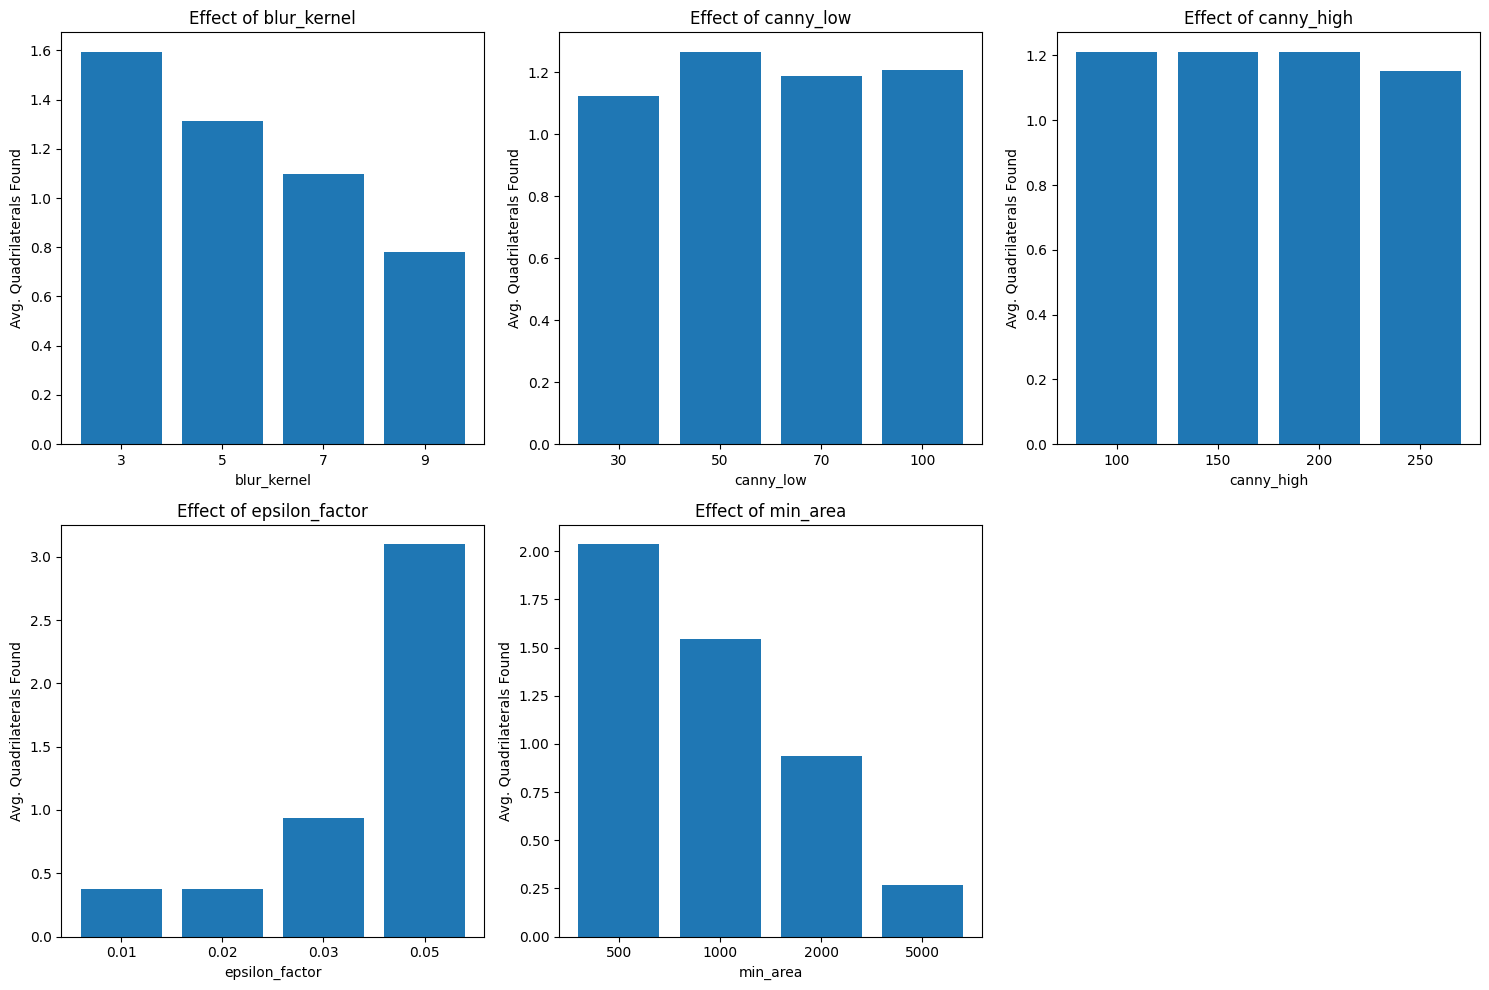


Visualizing top results...


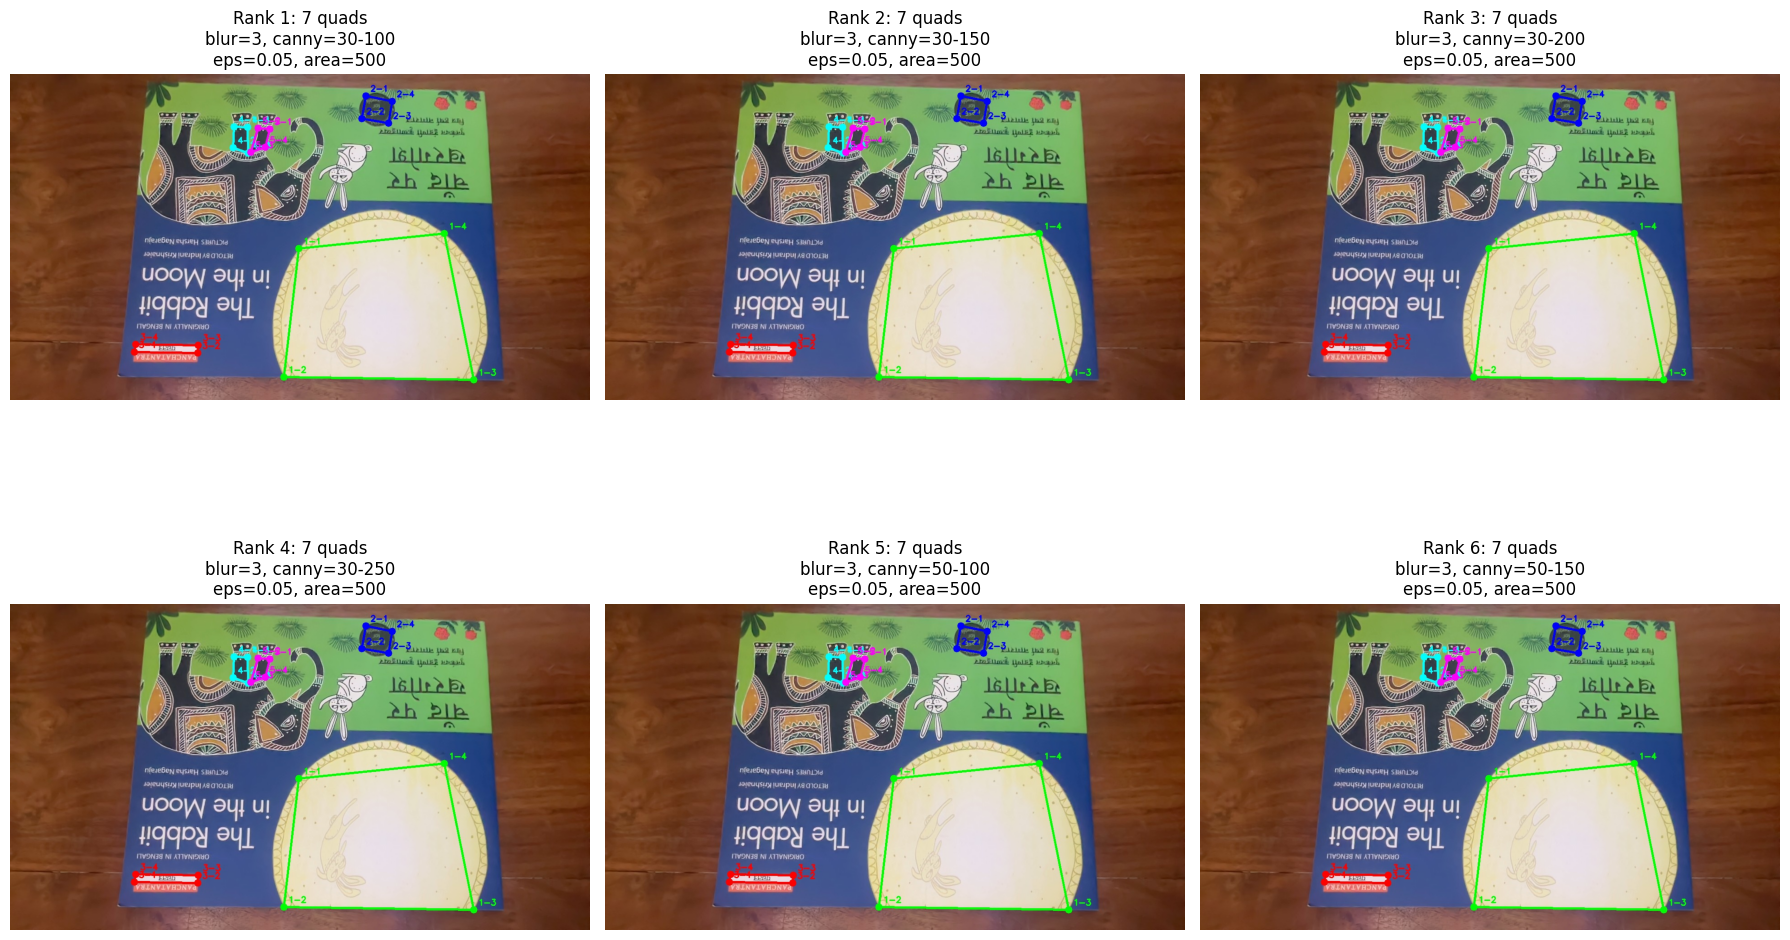

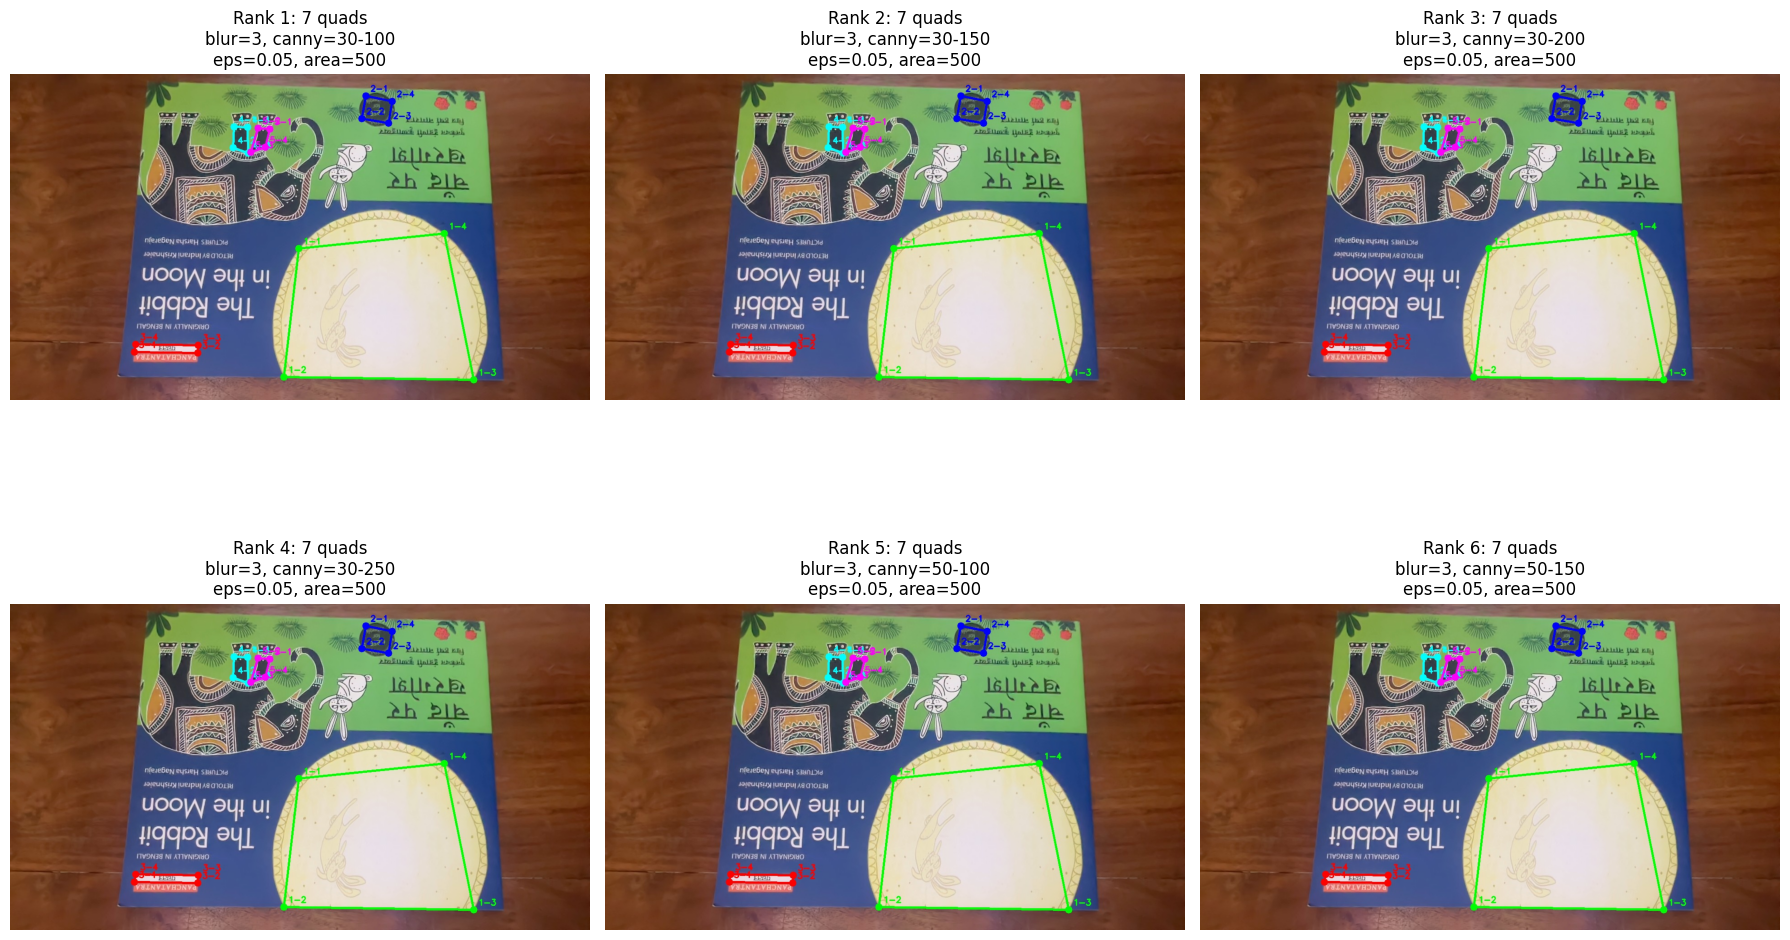

In [103]:
import json
import os
import matplotlib.pyplot as plt
import cv2

# Visualize results from best hyperparameter combinations
def visualize_top_results(base_output_dir="hyperparameter_results", top_n=6):
    """
    Visualize results from the top N hyperparameter combinations
    """
    # Check if summary file exists
    summary_file = os.path.join(base_output_dir, "hyperparameter_summary.json")
    if not os.path.exists(summary_file):
        print(f"Summary file not found: {summary_file}")
        print("Please run hyperparameter tuning first!")
        return
    
    # Load summary
    with open(summary_file, "r") as f:
        results = json.load(f)
    
    # Sort by number of quadrilaterals found
    sorted_results = sorted(results, key=lambda x: x['num_quadrilaterals'], reverse=True)
    
    # Create visualization
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    axes = axes.flatten()
    
    for i, result in enumerate(sorted_results[:top_n]):
        if i < len(axes):
            # Load contours image
            img_path = os.path.join(base_output_dir, result['directory'], "contours.jpg")
            if os.path.exists(img_path):
                img = cv2.imread(img_path)
                img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                
                axes[i].imshow(img_rgb)
                axes[i].set_title(f"Rank {i+1}: {result['num_quadrilaterals']} quads\n"
                                f"blur={result['parameters']['blur_kernel']}, "
                                f"canny={result['parameters']['canny_low']}-{result['parameters']['canny_high']}\n"
                                f"eps={result['parameters']['epsilon_factor']}, "
                                f"area={result['parameters']['min_area']}")
                axes[i].axis('off')
            else:
                axes[i].text(0.5, 0.5, f"Image not found\n{result['directory']}", 
                           ha='center', va='center', transform=axes[i].transAxes)
                axes[i].axis('off')
    
    plt.tight_layout()
    plt.savefig(os.path.join(base_output_dir, "top_results_visualization.png"), dpi=300, bbox_inches='tight')
    plt.show()

# Check if hyperparameter tuning has been run
if os.path.exists("hyperparameter_results/hyperparameter_summary.json"):
    print("Hyperparameter tuning results found. Analyzing...")
    sorted_results = analyze_results("hyperparameter_results")
    print("\nVisualizing top results...")
    visualize_top_results("hyperparameter_results", top_n=6)
else:
    print("No hyperparameter tuning results found.")
    print("Please run the hyperparameter tuning cell first!")

visualize_top_results(top_n=6)

In [104]:
import os
import json
from itertools import product

# Assuming other necessary imports and function definitions are above

# Quick test with smaller hyperparameter set (for faster testing)
def quick_hyperparameter_test(image_path, base_output_dir="quick_test_results"):
    """
    Quick test with a smaller set of hyperparameters
    """
    # Define smaller hyperparameter ranges for quick testing
    hyperparams = {
        'blur_kernel': [3, 5, 7],  # 3 values
        'canny_low': [30, 50],     # 2 values
        'canny_high': [100, 150],  # 2 values
        'epsilon_factor': [0.02, 0.03],  # 2 values
        'min_area': [1000, 2000]   # 2 values
    }
    
    # Create base output directory
    os.makedirs(base_output_dir, exist_ok=True)
    
    # Generate all combinations (3×2×2×2×2 = 48 combinations)
    param_combinations = list(product(*hyperparams.values()))
    param_names = list(hyperparams.keys())
    
    print(f"Quick testing {len(param_combinations)} hyperparameter combinations...")
    
    results_summary = []
    
    for i, params in enumerate(param_combinations):
        # Create parameter dictionary
        param_dict = dict(zip(param_names, params))
        
        # Create directory name from parameters
        dir_name = f"blur{param_dict['blur_kernel']}_canny{param_dict['canny_low']}-{param_dict['canny_high']}_eps{param_dict['epsilon_factor']}_area{param_dict['min_area']}"
        save_dir = os.path.join(base_output_dir, dir_name)
        
        # Run scanner with these parameters
        num_quads, original, edges, contours = document_scanner_with_hyperparams(
            image_path, 
            param_dict['blur_kernel'],
            param_dict['canny_low'],
            param_dict['canny_high'],
            param_dict['epsilon_factor'],
            param_dict['min_area'],
            save_dir
        )
        
        # Store results
        results_summary.append({
            'combination': i + 1,
            'parameters': param_dict,
            'num_quadrilaterals': num_quads,
            'directory': dir_name
        })
        
        # Print progress
        if (i + 1) % 10 == 0:
            print(f"Completed {i + 1}/{len(param_combinations)} combinations")
    
    # Save summary results
    with open(os.path.join(base_output_dir, "hyperparameter_summary.json"), "w") as f:
        json.dump(results_summary, f, indent=2)
    
    # Find best parameters
    best_result = max(results_summary, key=lambda x: x['num_quadrilaterals'])
    
    print(f"\nQuick test completed!")
    print(f"Total combinations tested: {len(param_combinations)}")
    print(f"Best result: {best_result['num_quadrilaterals']} quadrilaterals found")
    print(f"Best parameters: {best_result['parameters']}")
    
    return results_summary, best_result

# Run quick test first
print("Running quick hyperparameter test...")
quick_results, quick_best = quick_hyperparameter_test(image_path)

Running quick hyperparameter test...
Quick testing 48 hyperparameter combinations...
Completed 10/48 combinations
Completed 10/48 combinations
Completed 20/48 combinations
Completed 20/48 combinations
Completed 30/48 combinations
Completed 30/48 combinations
Completed 40/48 combinations
Completed 40/48 combinations

Quick test completed!
Total combinations tested: 48
Best result: 2 quadrilaterals found
Best parameters: {'blur_kernel': 5, 'canny_low': 30, 'canny_high': 100, 'epsilon_factor': 0.03, 'min_area': 1000}

Quick test completed!
Total combinations tested: 48
Best result: 2 quadrilaterals found
Best parameters: {'blur_kernel': 5, 'canny_low': 30, 'canny_high': 100, 'epsilon_factor': 0.03, 'min_area': 1000}


Top 5 results from quick test:
1. Quadrilaterals: 2
   Parameters: {'blur_kernel': 5, 'canny_low': 30, 'canny_high': 100, 'epsilon_factor': 0.03, 'min_area': 1000}
   Directory: blur5_canny30-100_eps0.03_area1000

2. Quadrilaterals: 2
   Parameters: {'blur_kernel': 5, 'canny_low': 30, 'canny_high': 150, 'epsilon_factor': 0.03, 'min_area': 1000}
   Directory: blur5_canny30-150_eps0.03_area1000

3. Quadrilaterals: 2
   Parameters: {'blur_kernel': 5, 'canny_low': 50, 'canny_high': 100, 'epsilon_factor': 0.03, 'min_area': 1000}
   Directory: blur5_canny50-100_eps0.03_area1000

4. Quadrilaterals: 2
   Parameters: {'blur_kernel': 5, 'canny_low': 50, 'canny_high': 150, 'epsilon_factor': 0.03, 'min_area': 1000}
   Directory: blur5_canny50-150_eps0.03_area1000

5. Quadrilaterals: 2
   Parameters: {'blur_kernel': 7, 'canny_low': 50, 'canny_high': 100, 'epsilon_factor': 0.03, 'min_area': 1000}
   Directory: blur7_canny50-100_eps0.03_area1000



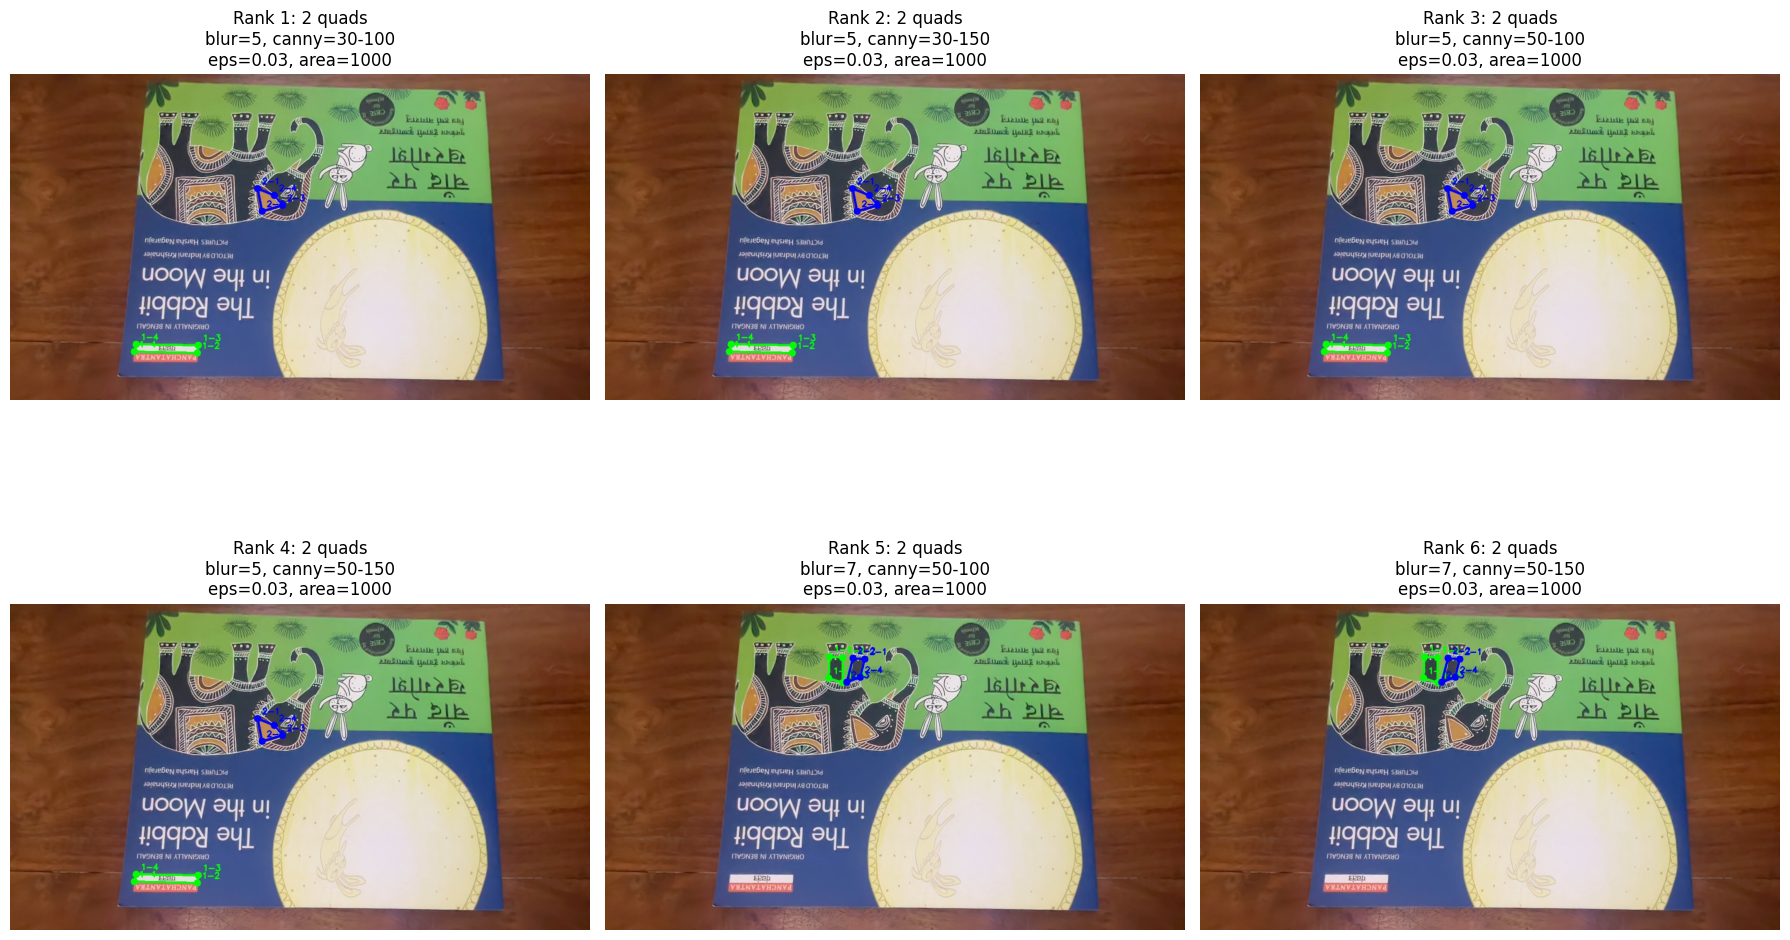

In [105]:
# Visualize quick test results
def visualize_quick_results(base_output_dir="quick_test_results"):
    """
    Visualize results from the quick hyperparameter test
    """
    summary_file = os.path.join(base_output_dir, "hyperparameter_summary.json")
    if not os.path.exists(summary_file):
        print(f"Summary file not found: {summary_file}")
        return
    
    with open(summary_file, "r") as f:
        results = json.load(f)
    
    # Sort by number of quadrilaterals found
    sorted_results = sorted(results, key=lambda x: x['num_quadrilaterals'], reverse=True)
    
    print("Top 5 results from quick test:")
    print("=" * 60)
    for i, result in enumerate(sorted_results[:5]):
        print(f"{i+1}. Quadrilaterals: {result['num_quadrilaterals']}")
        print(f"   Parameters: {result['parameters']}")
        print(f"   Directory: {result['directory']}")
        print()
    
    # Create visualization of top 6 results
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    axes = axes.flatten()
    
    for i, result in enumerate(sorted_results[:6]):
        if i < len(axes):
            # Load contours image
            img_path = os.path.join(base_output_dir, result['directory'], "contours.jpg")
            if os.path.exists(img_path):
                img = cv2.imread(img_path)
                img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                
                axes[i].imshow(img_rgb)
                axes[i].set_title(f"Rank {i+1}: {result['num_quadrilaterals']} quads\n"
                                f"blur={result['parameters']['blur_kernel']}, "
                                f"canny={result['parameters']['canny_low']}-{result['parameters']['canny_high']}\n"
                                f"eps={result['parameters']['epsilon_factor']}, "
                                f"area={result['parameters']['min_area']}")
                axes[i].axis('off')
            else:
                axes[i].text(0.5, 0.5, f"Image not found", 
                           ha='center', va='center', transform=axes[i].transAxes)
                axes[i].axis('off')
    
    plt.tight_layout()
    plt.savefig(os.path.join(base_output_dir, "quick_test_visualization.png"), dpi=300, bbox_inches='tight')
    plt.show()

# Visualize the quick test results
visualize_quick_results("quick_test_results")